In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import itertools



In [2]:
file_path = '/data/users/kgruber/other-data/TX/'
era_path = '/data/users/kgruber/Data/era5/TX/'

clip population 30km resolution to TX boundaries

In [84]:
inRaster = file_path + 'gpw_v4_population_count_rev11_2020_15_min.tif'
outRaster = file_path + '/clip_pop_30.tif'
CLIP = file_path + '/shp/State_Boundary.shp'
cmd = 'gdalwarp -q -cutline %s -crop_to_cutline %s %s' % (CLIP, inRaster, outRaster)
os.system(cmd)

0

clip population 1km resolution  to TX boundaries

In [86]:
inRaster = file_path + '/gpw_v4_population_count_rev11_2020_30_sec.tif'
outRaster = file_path + '/clip_pop_1.tif'
CLIP = file_path + '/shp/State_Boundary.shp'
cmd = 'gdalwarp -q -cutline %s -crop_to_cutline %s %s' % (CLIP, inRaster, outRaster)
os.system(cmd)

0

load population data

In [3]:
pop30 = xr.open_rasterio(file_path + '/clip_pop_30.tif')
pop1 = xr.open_rasterio(file_path + '/clip_pop_1.tif')

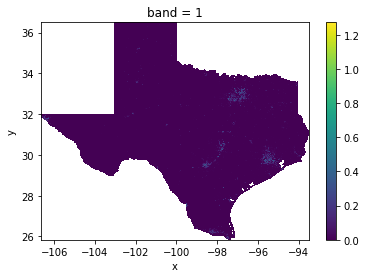

In [11]:
(pop1.where(pop1>=0,np.nan)/10000).plot()

In [132]:
# replace negative values by 0
pop1 = pop1.where(pop1>=0,np.nan)

load temperature data

In [95]:
temp195001 = xr.open_dataset(era_path + 'era5_temp_TX_195001.nc')

population and era5 do not have the same resolution

In [101]:
pop30.x == temp195001.longitude

<xarray.DataArray (x: 53, longitude: 57)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * x          (x) float64 -106.5 -106.3 -106.0 -105.8 ... -94.13 -93.88 -93.63
  * longitude  (longitude) float32 -107.0 -106.75 -106.5 ... -93.5 -93.25 -93.0

# aggreate population to era5 tiles

In [124]:
def getPOPsumtile(ij):
    lon = ij.lon
    lat = ij.lat
    lonmin = lon - 0.125
    lonmax = lon + 0.125
    lons = pop1.x[(pop1.x>=lonmin)&(pop1.x<lonmax)].values
    latmin = lat - 0.125
    latmax = lat + 0.125
    lats = pop1.y[(pop1.y>=latmin)&(pop1.y<latmax)].values
    return(float(pop1.sel(x=lons,y=lats).mean().values))

In [102]:
templons = list(temp195001.longitude.values)
templats = list(temp195001.latitude.values)

In [133]:
lonlats = pd.DataFrame(itertools.product(templons, templats),columns=['lon','lat'])

In [134]:
lonlats['sum_pop'] = lonlats.apply(getPOPsumtile,axis=1)

/home/kgruber/.conda/envs/py37/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [135]:
pop1_era5 = lonlats.sum_pop.values.reshape((len(templons),len(templats))).transpose()

In [ ]:
plt.imshow(pop1_era5)

relative poplulation

In [142]:
pop1_rel = pop1_era5/np.nansum(pop1_era5)

In [ ]:
plt.imshow(pop1_rel)

make xarray

In [146]:
pop_era5_rel = xr.DataArray(data=pop1_rel, 
                       coords={'latitude':templats,'longitude':templons}, 
                       dims=['latitude','longitude'], name='rel_pop')

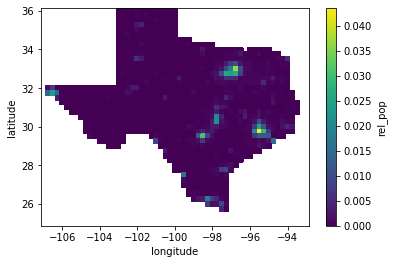

In [147]:
pop_era5_rel.plot()

In [149]:
# save
pop_era5_rel.to_netcdf(file_path + '/pop_era5_rel.nc')